<a href="https://colab.research.google.com/github/luisamariarodriguez/F_monografia_esp_analitica_ciencia_datos_2024./blob/main/Code/040_Modelo_Recortadas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# UNSUPERVISED ANOMALY SEGMENTATION
### This is a implementation of **DFR: Deep Feature Reconstruction for Unsupervised Anomaly Segmentation** https://arxiv.org/abs/2012.07122
#### We train only with OK images, and then we predict a hotmap, where high areas are presumably anomalous
#### The pretrained weights provided by me (input anomalysegmentation-weights) are not very good because Kaggle limits training time to 9hrs

## IMPORTS

In [ ]:
!pip install tqdm

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from skimage import io
from skimage.transform import resize

import numpy as np

from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import cv2

import random
import os
from tqdm import tqdm

from random import randrange

## Custom Data Generator

In [ ]:
input_directory = f"/content/drive/MyDrive/muestra_PIXAI_final/pixai_dataset_final_recortadas"
input_directory_test = f"/content/drive/MyDrive/muestra_PIXAI_final/pixai_dataset_final_recortadas/test"
classes = ['anomaly', 'good']

In [ ]:
input_model_filepath = "../input/anomalysegmentation-weights/anomaly-segmentation-model_vgg19.h5"
output_model_filepath = "./anomaly-segmentation-model.h5"

In [ ]:
class CustomDataGen(tf.keras.utils.Sequence):

    def __init__(self, path = input_directory,
                 batch_size = 4,
                 input_size=(224, 224),
                 shuffle=True, seed = None, subset = 'training'):

        self.image_data_generator = ImageDataGenerator(rescale=1. / 255, data_format='channels_last',
            #zoom_range = 0.1,
            #width_shift_range = 0.05,
            #height_shift_range = 0.05,
            #brightness_range=(0.95,1.05)
        )

        if seed is None:
            random.randint(0, 2**32)

        self.batch_size = batch_size
        self.input_size = input_size

        self.X_paths = [os.fsdecode(file) for file in os.scandir(f"{path}/train/good")]
        self.X_train, self.X_val = train_test_split(self.X_paths, test_size=0.2, random_state = seed, shuffle = True)

        if subset == 'training':
            self.X = self.X_train
        elif subset == 'validation':
            self.X = self.X_val

        self.n = len(self.X)


    def __getitem__(self, index):

        data_x = []

        for i in range(self.batch_size):
            image = cv2.imread(self.X[self.batch_size * index + i])

            image = self.image_data_generator.random_transform(image)

            image = image / 255

            image = tf.image.resize(image, self.input_size)
            data_x.append(image)

        data_x = np.array(data_x)

        return data_x, data_x

    def __len__(self):
        return self.n // self.batch_size

In [ ]:
INPUT_SIZE = (224,224)
seed = random.randint(0, 2**32)
train_datagen = CustomDataGen(input_size = INPUT_SIZE, batch_size = 4, seed = seed)
validation_datagen = CustomDataGen(input_size = INPUT_SIZE, subset = "validation", seed = seed)

In [ ]:
#Check we dont have the same images in train and validation sets
any([value in train_datagen.X for value in validation_datagen.X])

False

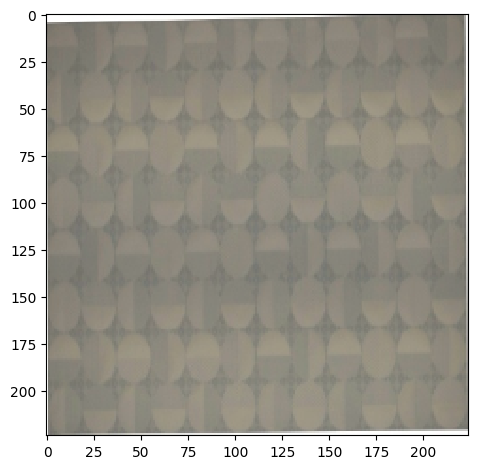

In [ ]:
x, y = train_datagen[0]
io.imshow(x[0])
io.show()

## Model

In [ ]:
#model class
#Implementation of DFR: Deep Feature Reconstruction for Unsupervised Anomaly Segmentation https://arxiv.org/abs/2012.07122
class AnomalySegmentator(tf.keras.Model):
    def __init__(self, init_layer = 0, end_layer = None):
        super(AnomalySegmentator, self).__init__()
        #self.L2_weight = 1e-6
        self.init_layer = init_layer
        self.end_layer = end_layer

    def build_autoencoder(self, c0, cd):
        self.autoencoder = Sequential([
            layers.InputLayer((self.map_shape[0]//4, self.map_shape[1]//4, c0)),
            layers.Conv2D((c0 + cd) // 2,(1,1), padding='same', activation = tf.keras.layers.LeakyReLU(alpha=0.1)),
            layers.Conv2D(2*cd,(1,1), padding='same', activation = tf.keras.layers.LeakyReLU(alpha=0.1)),
            layers.Conv2D(cd,(1,1), padding='same'),
            layers.Conv2D(2*cd,(1,1), padding='same', activation = tf.keras.layers.LeakyReLU(alpha=0.1)),
            layers.Conv2D((c0 + cd) // 2,(1,1), padding='same', activation = tf.keras.layers.LeakyReLU(alpha=0.1)),
            layers.Conv2D(c0,(1,1), padding='same')
        ])

    def build(self, input_shape):

        self.vgg = VGG19(include_top = False, weights = 'imagenet', input_shape=input_shape[1:])
        self.features_list = [layer.output for layer in self.vgg.layers if 'conv' in layer.name][self.init_layer:self.end_layer]

        self.feature_extractor = Model(inputs = self.vgg.input,
                                       outputs = self.features_list)
        self.feature_extractor.trainable = False

        self.threshold = tf.Variable(0, trainable = False, dtype = tf.float32)

        self.map_shape = self.features_list[0].shape[1:-1]

        self.average_pooling = layers.AveragePooling2D(pool_size=(4, 4), strides=(4,4))



        self.c0 = sum([feature.shape[-1] for feature in self.features_list])
        self.cd = 40
        self.build_autoencoder(self.c0, self.cd)


    def call(self, inputs):
        features = self.feature_extractor(inputs)
        resized_features = [tf.image.resize(feature, self.map_shape) for feature in features]
        resized_features = tf.concat(resized_features, axis = -1)

        resized_features = self.average_pooling(resized_features)

        autoencoder_output = self.autoencoder(resized_features)
        return tf.reduce_sum((autoencoder_output - resized_features)**2, axis = -1)

    def reconstruction_loss(self):
        @tf.function
        def _loss(y_true, y_pred):
            loss = tf.reduce_mean(y_pred, axis = (1,2)) / (tf.cast(tf.shape(y_pred)[0], tf.float32) * self.c0)
            return loss

        return _loss

    def compute_threshold(self, data_loader, fpr = 0.05):
      error = []
      for i in tqdm(range(len(data_loader))):
        x, y = data_loader[i]
        error.append(self(x))

      threshold = np.percentile(error, 100 - fpr)
      self.threshold = tf.Variable(threshold, trainable = False, dtype = tf.float32)

    def compute_pca(self, data_loader):
        extraction_per_sample = 20

        extractions = []
        for i in tqdm(range(len(data_loader))):
            x, _ = data_loader[i]

            features = self.feature_extractor(x)
            resized_features = [tf.image.resize(feature, self.map_shape) for feature in features]
            resized_features = tf.concat(resized_features, axis = -1)

            resized_features = self.average_pooling(resized_features)

            for feature in resized_features:

                for _ in range(extraction_per_sample):

                    row, col = randrange(feature.shape[0]), randrange(feature.shape[1])
                    extraction = feature[row, col]
                    extractions.append(extraction)

        extractions = np.array(extractions)
        print(f"Extractions Shape: {extractions.shape}")
        pca = PCA(0.9, svd_solver = "full")
        pca.fit(extractions)
        self.cd = pca.n_components_
        self.build_autoencoder(self.c0, self.cd)
        print(f"Components with explainable variance 0.9 -> {self.cd}")

In [ ]:
as_model = AnomalySegmentator()
as_model.compile(Adam(1e-4), loss = as_model.reconstruction_loss())

In [ ]:
as_model.build((None, *INPUT_SIZE,3))
as_model.compute_pca(train_datagen)

100%|██████████| 19/19 [00:02<00:00,  6.49it/s]


Extractions Shape: (1520, 5504)
Components with explainable variance 0.9 -> 17


## Training

Epoch 1/60
19/19 [==============================] - 9s 389ms/step - loss: 7.7111 - val_loss: 2.8275 - lr: 1.0000e-04
Epoch 2/60
19/19 [==============================] - 8s 414ms/step - loss: 2.0773 - val_loss: 1.6019 - lr: 1.0000e-04
Epoch 3/60
19/19 [==============================] - 8s 376ms/step - loss: 1.4067 - val_loss: 1.2325 - lr: 1.0000e-04
Epoch 4/60
19/19 [==============================] - 7s 379ms/step - loss: 1.1341 - val_loss: 1.0391 - lr: 1.0000e-04
Epoch 5/60
19/19 [==============================] - 7s 396ms/step - loss: 0.9314 - val_loss: 0.8268 - lr: 1.0000e-04
Epoch 6/60
19/19 [==============================] - 8s 403ms/step - loss: 0.7421 - val_loss: 0.6809 - lr: 1.0000e-04
Epoch 7/60
19/19 [==============================] - 8s 417ms/step - loss: 0.6321 - val_loss: 0.5876 - lr: 1.0000e-04
Epoch 8/60
19/19 [==============================] - 8s 400ms/step - loss: 0.5574 - val_loss: 0.5273 - lr: 1.0000e-04
Epoch 9/60
19/19 [==============================] - 8s 413ms/ste

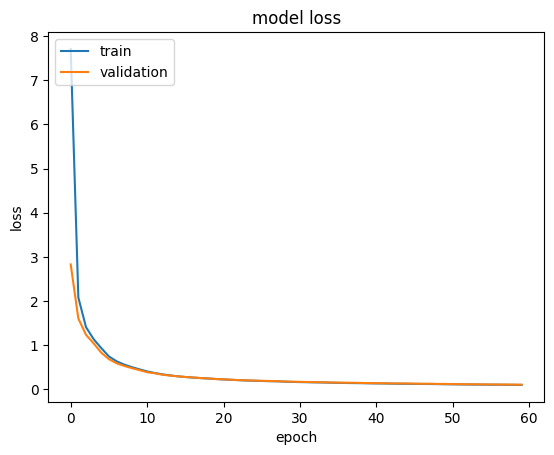

100%|██████████| 19/19 [00:04<00:00,  3.88it/s]


In [ ]:
#True if we want to train the model
if True:
    # Training the model
    plateau = tf.keras.callbacks.ReduceLROnPlateau(
      monitor='val_loss', factor=0.5, patience=5, verbose = 1
    )
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                                          patience=15)  # Early stopping (stops training when validation doesn't improve for {patience} epochs)
    save_best = tf.keras.callbacks.ModelCheckpoint(output_model_filepath, monitor='val_loss', save_best_only=True,
                                                mode='min', save_weights_only = True)  # Saves the best version of the model to disk (as measured on the validation data set)

    history = as_model.fit(train_datagen,
        epochs=50,
        validation_data=validation_datagen,
        shuffle=True,
        callbacks=[es, save_best, plateau])
    #Training history
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    as_model.load_weights(output_model_filepath)
    as_model.compute_threshold(train_datagen)
    as_model.save_weights(output_model_filepath)
else:

    as_model.build((None, *INPUT_SIZE,3))
    as_model.load_weights(input_model_filepath)
    as_model.compute_threshold(train_datagen)
    as_model.summary()
    as_model.autoencoder.summary()

# TESTING

In [ ]:
# Importar las bibliotecas necesarias
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from skimage.transform import resize

# Crear el generador de datos de prueba
test_datagen = ImageDataGenerator(rescale=1. / 255, data_format='channels_last')
test_generator = test_datagen.flow_from_directory(input_directory_test,
                                                  target_size=INPUT_SIZE,
                                                  batch_size=1,
                                                  class_mode='sparse')

true_labels = []
predictions = []

for i in range(115):
    x_batch, y_batch = next(test_generator)
    hotmaps = as_model(x_batch)
    for x, y, hotmap in zip(x_batch, y_batch, hotmaps):

        prediction = np.any(hotmap > as_model.threshold)

        # Guardar los valores binarios
        true_labels.append(1 if classes[int(y)] == 'anomaly' else 0)  # 1 si es anomaly, 0 si es good
        predictions.append(1 if prediction else 0)  # 1 si Anomaly detected es True, 0 si es False

        # Redimensionar el hotmap (opcional si necesitas hacer algo con él)
        hotmap = resize(hotmap, x.shape[:-1], anti_aliasing=True)

        # (Opcional) Puedes descomentar esta parte si necesitas calcular la máscara
        # mask = np.where(hotmap > as_model.threshold, 1, 0)

        # (Opcional) Mostrar información adicional
        # print(f"Threshold: {as_model.threshold.numpy()} MaxValue: {hotmap.max()}")
        # print(f"Directory: {classes[int(y)]}, Anomaly detected: {prediction}")

# Mostrar los resultados binarios recolectados
print("True Labels:", true_labels)
print("Predictions:", predictions)

Found 118 images belonging to 2 classes.
True Labels: [1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0]
Predictions: [1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0]


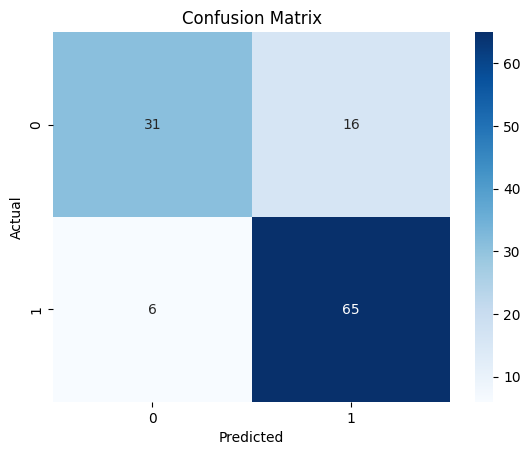

Confusion Matrix:
[[31 16]
 [ 6 65]]
Accuracy: 0.8135593220338984
Precision: 0.8024691358024691
Recall: 0.9154929577464789
F1 Score: 0.8552631578947367
True Labels: [1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0
 0 1 1 0 1 0 1 1 0 1 1 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 0 0 1 0
 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 0 0 1 1 1 0 0 0 0 1 1
 1 1 1 1 0 1 0]
Predictions: [1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 0 0 1 1 0 1 1 0 0 0 1 1 0 0
 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 1 0 1 1
 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1
 1 1 1 1 0 1 0]


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convertir listas a numpy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predictions)

# Calcular indicadores de rendimiento
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

# Mostrar la matriz de confusión
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Imprimir la matriz de confusión y los indicadores de rendimiento
print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Mostrar los resultados binarios recolectados
print("True Labels:", true_labels)
print("Predictions:", predictions)
